In [26]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import os
import functions as ff
import nibabel as nb
import nilearn as ni
from nilearn.image import resample_img
from nilearn.image import get_data

In [11]:
grid = np.mgrid[0:192, 0:128]
circle = np.sum(
    (grid - np.array([32, 32])[:, np.newaxis, np.newaxis]) ** 2,
    axis=0) < 256
diamond = np.sum(
    np.abs(grid - np.array([128, 80])[:, np.newaxis, np.newaxis]),
    axis=0) < 16
rectangle = np.max(np.abs(
    grid - np.array([64, 96])[:, np.newaxis, np.newaxis]), axis=0) < 16

(192, 128)


Text(0.5, 1.0, 'The original data in voxel space')

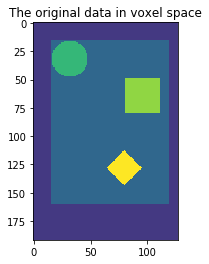

In [46]:
image = np.zeros_like(circle)
image[16:160, 16:120] = 1.
image = image + 2 * circle + 3 * rectangle + 4 * diamond + 1
vmax = image.max()
print(image.shape)
plt.figure()
plt.imshow(image, interpolation="nearest", vmin=0, vmax=vmax)
plt.title("The original data in voxel space")


In [50]:
source_affine = np.eye(4)
# Use canonical vectors for affine
# Give the affine an offset
source_affine[:2, 3] = np.array([96, 64])

angle = np.pi / 180 * 45
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
source_affine[:2, :2] = rotation_matrix * 2  # 2.0mm voxel size

print(source_affine)

[[ 1.41421356 -1.41421356  0.         96.        ]
 [ 1.41421356  1.41421356  0.         64.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [53]:
img = nb.Nifti1Image(image[:, :, np.newaxis].astype("int32"),
                          affine=source_affine)
print(img.shape)

(192, 128, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


Text(0.5, 1.0, 'The original data in mm space')

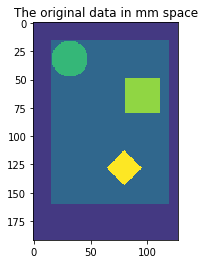

In [56]:
plt.figure()
plt.imshow(img.get_data()[:, :, 0], vmin=0, vmax=vmax)
plt.title("The original data in mm space")

In [71]:
img_in_mm_space = resample_img(img, target_affine=np.eye(4),
                               target_shape=(512, 512, 1))

target_affine_3x3 = np.eye(3) * 2
target_affine_4x4 = np.eye(4) * 2
target_affine_4x4[3, 3] = 1.
img_3d_affine = resample_img(img, target_affine=target_affine_3x3)
img_4d_affine = resample_img(img, target_affine=target_affine_4x4)
target_affine_mm_space_offset_changed = np.eye(4)
target_affine_mm_space_offset_changed[:3, 3] = \
    img_3d_affine.affine[:3, 3]
print(target_affine_4x4)
print(img_in_mm_space.affine)
print(img_3d_affine.affine)
print(img_4d_affine.affine)

[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[  2.           0.           0.         -83.60512242]
 [  0.           2.           0.          64.        ]
 [  0.           0.           2.           0.        ]
 [  0.           0.           0.           1.        ]]
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]


/home/zc13/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/zc13/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/zc13/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [72]:
img_3d_affine_in_mm_space = resample_img(
    img_3d_affine,
    target_affine=target_affine_mm_space_offset_changed,
    target_shape=(np.array(img_3d_affine.shape) * 2).astype(int))

img_4d_affine_in_mm_space = resample_img(
    img_4d_affine,
    target_affine=np.eye(4),
    target_shape=(np.array(img_4d_affine.shape) * 2).astype(int))

print(img_4d_affine_in_mm_space.affine)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


/home/zc13/.local/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


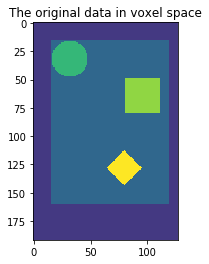

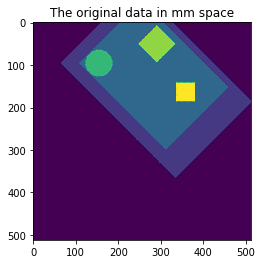

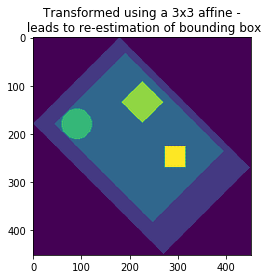

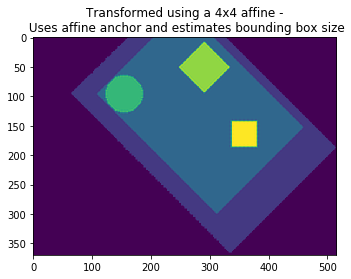

In [73]:
import matplotlib.pyplot as plt
from nilearn.plotting import show
plt.figure()
plt.imshow(image, interpolation="nearest", vmin=0, vmax=vmax)
plt.title("The original data in voxel space")

plt.figure()
plt.imshow(get_data(img_in_mm_space)[:, :, 0], vmin=0, vmax=vmax)
plt.title("The original data in mm space")

plt.figure()
plt.imshow(get_data(img_3d_affine_in_mm_space)[:, :, 0],
           vmin=0, vmax=vmax)
plt.title("Transformed using a 3x3 affine -\n leads to "
          "re-estimation of bounding box")

plt.figure()
plt.imshow(get_data(img_4d_affine_in_mm_space)[:, :, 0],
           vmin=0, vmax=vmax)
plt.title("Transformed using a 4x4 affine -\n Uses affine anchor "
          "and estimates bounding box size")

show()

In [4]:
# load a sample CT image
filename = '/workspace/CTProjector/data/example_CT_volume/3.nii.gz'
ct = sitk.ReadImage(filename)

[1.         0.68359399 0.68359399]
(418, 630, 630)


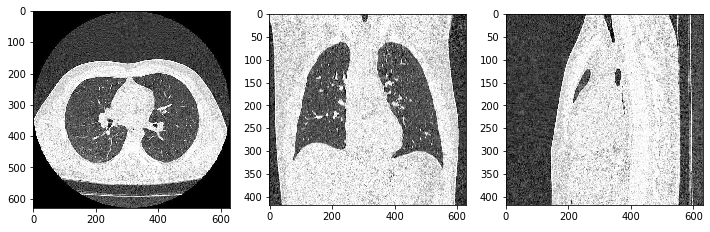

In [8]:
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)
img = img[::-1, ...]
spacing = np.array(spacing[::-1])
print(spacing)
print(img.shape)

img = (img.astype(np.float32) + 1024)
plt.figure(figsize = (12,4))

# plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(131); plt.imshow(img[200, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[:, img.shape[1]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[..., img.shape[2]//2], 'gray', aspect=spacing[0] / spacing[1])